<a href="https://colab.research.google.com/github/Divyanshu-Singh-Chauhan/Image-Forgery-Detection/blob/DL/DL_Simple1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""from google.colab import drive
drive.mount('/content/drive')"""
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab Notebooks/


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import os 
os.chdir('/content')
#os.chdir('drive')

In [4]:
#nor_es
import os
import io
import numpy as np
from keras.preprocessing import image
import pandas as pd
from PIL import Image, ImageChops, ImageEnhance
import os
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Model, Sequential 
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf




Using TensorFlow backend.


In [0]:
def jpeg_compression(img: Image.Image, quality: int=90) -> Image.Image:
    if img.mode != 'RGB':
        img = img.convert('RGB')
    buffer = io.BytesIO()
    img.save(buffer, format='JPEG', quality=quality)
    im_data = buffer.getvalue()
    img = Image.open(io.BytesIO(im_data))
    buffer.close()
    return img


In [0]:
def convert_to_ela(img):
    im = img.convert('RGB')
    resaved_im = jpeg_compression(im)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

In [0]:
#Defining Parameters
batch_size = 100
nb_epochs = 30
img_width = 128
img_height = 128
data_path = "/content/drive/My Drive/casia_ela"

In [0]:
#### MODEL DEFINING

model = tf.keras.models.Sequential([# Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)       

In [0]:
#optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['acc'])

In [0]:
###### CALLBACKS ##########


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### EARLYSTOPPING CALLBACK
# early_stopping = EarlyStopping(monitor='val_acc',
#                                min_delta=0,
#                                patience=2,
#                                verbose=0, mode='auto')

### MODELCHECKPOINT CALLBACK
save = ModelCheckpoint('/content/drive/My Drive/weights/w.h5', save_best_only=True, monitor='val_loss', mode='min')

### REDUCES LR WHEN METRTIC IS NOT IMPROVING
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta =1e-4, mode='min')

### LEARNING RATE SCHEDULER
def scheduler(epoch):
  if epoch < 5:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (5 - epoch))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)    

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [0]:
import os
os.chdir('/content')

In [49]:
train_data = train_datagen.flow_from_directory(
    data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

Found 11469 images belonging to 2 classes.


In [50]:
validation_data = train_datagen.flow_from_directory(
    data_path, # same directory as training data
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

Found 2866 images belonging to 2 classes.


In [0]:
path_to_weights = '/content/drive/My Drive/weights/w.h5'
model.load_weights(path_to_weights)

In [52]:
history = model.fit(
            train_data,
            steps_per_epoch = train_data.samples // batch_size,
            validation_data = validation_data, 
            validation_steps = validation_data.samples // batch_size,
            epochs = 30,
            callbacks = [save, lr_schedule])

Epoch 1/30
114/114 [==============================] - 114s 996ms/step - loss: 0.2117 - acc: 0.9115 - val_loss: 1.3416 - val_acc: 0.6621 - lr: 0.0010
Epoch 2/30
114/114 [==============================] - 113s 988ms/step - loss: 0.1932 - acc: 0.9229 - val_loss: 1.8586 - val_acc: 0.5371 - lr: 0.0010
Epoch 3/30
114/114 [==============================] - 112s 983ms/step - loss: 0.1946 - acc: 0.9259 - val_loss: 1.1113 - val_acc: 0.6514 - lr: 0.0010
Epoch 4/30
114/114 [==============================] - 111s 975ms/step - loss: 0.1859 - acc: 0.9292 - val_loss: 1.6275 - val_acc: 0.6811 - lr: 0.0010
Epoch 5/30
114/114 [==============================] - 110s 969ms/step - loss: 0.1795 - acc: 0.9303 - val_loss: 1.0954 - val_acc: 0.6314 - lr: 0.0010
Epoch 6/30
114/114 [==============================] - 111s 972ms/step - loss: 0.1682 - acc: 0.9333 - val_loss: 2.1969 - val_acc: 0.6871 - lr: 0.0010
Epoch 7/30
114/114 [==============================] - 110s 963ms/step - loss: 0.1620 - acc: 0.9370 - val_l

In [53]:
 print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


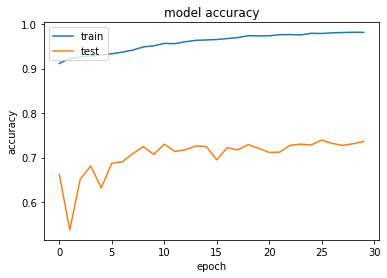

In [54]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



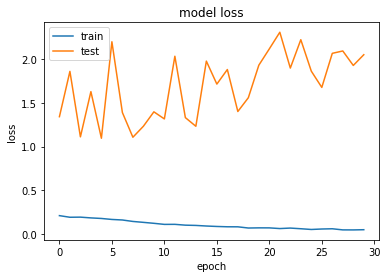

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(validation_data, validation_data.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_data.classes, y_pred))


print('Classification Report')
target_names = ['Aut', 'Tamp']
print(classification_report(validation_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[1658    0]
 [1208    0]]
Classification Report
              precision    recall  f1-score   support

         Aut       0.58      1.00      0.73      1658
        Tamp       0.00      0.00      0.00      1208

    accuracy                           0.58      2866
   macro avg       0.29      0.50      0.37      2866
weighted avg       0.33      0.58      0.42      2866



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
